<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Desafío 3 - Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.losses import SparseCategoricalCrossentropy

### Datos
Como corpus utilizaremos el autodenominado album de Avenged Sevenfold, una banda de metal estadounidense formada en 1999 en Huntington Beach, California.

Su estilo musical ha evolucionado a lo largo de los años, comenzando con influencias del metalcore en sus primeros discos y luego expandiéndose hacia un sonido más melódico y variado que incluye elementos de heavy metal, hard rock e incluso música clásica.

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('../../../datasets/avenged_lyrics.txt', sep='/n', header=None, engine='python')

# Filter out rows that start with '['
df = df[~df[0].str.startswith('[')]

df.head()

,0
0,1. Critical Acclaim
1,"Shhh... quiet, you might piss somebody off"
2,"Like me, motherfucker, you've been at it for t..."
3,While you feed off others' insecurities
4,You stand in front of me and bite the hand tha...


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 533


Si bien no tenemos muchos documentos, veamos qué tal es el desempeño de nuestro modelo bajo este fundamento de un corpus mas pequeño

### Elegir el tamaño del contexto

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding


In [7]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['1. Critical Acclaim',
 'Shhh... quiet, you might piss somebody off',
 "Like me, motherfucker, you've been at it for too long",
 "While you feed off others' insecurities",
 'You stand in front of me and bite the hand that feeds',
 '(Self-righteousness is wearing thin)',
 'Lies inside your head your best friend',
 '(Heart bleeds but not for fellow men)',
 'Broken glass, your fake reflection',
 "I've had enough",
 "It's time for something real",
 "I don't respect the words you're speaking",
 'Gone too far, a clone',
 "So how does it feel to know that someone's kid in the heart of America",
 'Has blood on their hands fighting to defend your rights',
 "So you can maintain a lifestyle that insults his family's existence?",
 "Well, where I'm from we have a special salute we aim high in the air",
 'Towards all those pompous assholes who spend their days pointing fingers',
 'Fuck you',
 'Shh... quiet, you might piss somebody off',
 'Like the heartbeat of this country when antagonized too long

In [8]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [9]:
text[3]

"While you feed off others' insecurities"

In [10]:
segmented_sentences[0]

['1', 'critical', 'acclaim']

In [11]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 7.,  0., 21.,  0.,  0., 22.,  0.,  0., 57.,  0., 47.,  0.,  0.,
        79.,  0.,  0., 74.,  0., 55.,  0.,  0., 53.,  0.,  0., 41.,  0.,
        27.,  0.,  0., 21.,  0.,  0., 12.,  0.,  9.,  0.,  0.,  6.,  0.,
         2.]),
 array([ 1.   ,  1.375,  1.75 ,  2.125,  2.5  ,  2.875,  3.25 ,  3.625,
         4.   ,  4.375,  4.75 ,  5.125,  5.5  ,  5.875,  6.25 ,  6.625,
         7.   ,  7.375,  7.75 ,  8.125,  8.5  ,  8.875,  9.25 ,  9.625,
        10.   , 10.375, 10.75 , 11.125, 11.5  , 11.875, 12.25 , 12.625,
        13.   , 13.375, 13.75 , 14.125, 14.5  , 14.875, 15.25 , 15.625,
        16.   ]),
 <BarContainer object of 40 artists>)

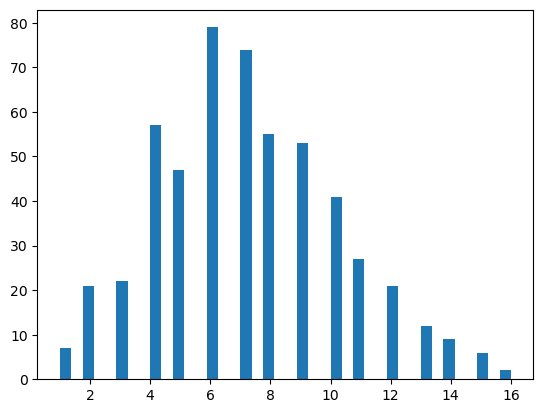

In [12]:
# podemos ver su distribución
plt.hist(length_sentences,bins=40)

In [13]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
#max_context_size = int(np.percentile(length_sentences, 10)-1)

max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
#max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 8


El criterio de percentil no lo considero de mayor relevancia debido a que en mi opinion no captura la totalidad del espectro contextual deseado de documentos.

Debido a esto, tomamos como max_context_size el criterio de media, el cual prevalece sobre el criterio de mediana por solamente un documento de diferencia.

Obviamente esta eleccion es a dedo y muy subjetiva, pero es preferible el approach de 'mientras más mejor', sobre todo al trabajar con modelos secuenciales de aprendizaje y tambien tomando en cuenta el pequeño tamaño de nuestro corpus original.

###  Tokenizar

In [14]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [15]:
tokenized_sentences[0]

[427, 428, 429]

In [16]:
segmented_sentences[0]

['1', 'critical', 'acclaim']

### Organizando y estructurando el dataset

In [17]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [18]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [19]:
len(tok_sent)

685

Estructuramos un 'many to many' no lineal

In [20]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [21]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [22]:
train_seqs.shape

(4514, 9)

In [23]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [24]:
y.shape

(4514, 8)

In [25]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'the',
 3: 'to',
 4: 'you',
 5: 'and',
 6: "i'm",
 7: 'this',
 8: 'a',
 9: 'so',
 10: 'me',
 11: 'of',
 12: 'but',
 13: 'my',
 14: 'all',
 15: 'for',
 16: 'that',
 17: 'your',
 18: 'not',
 19: "it's",
 20: 'in',
 21: 'on',
 22: 'it',
 23: 'time',
 24: 'we',
 25: "'cause",
 26: 'with',
 27: 'again',
 28: 'from',
 29: 'when',
 30: 'right',
 31: 'been',
 32: "don't",
 33: 'life',
 34: 'know',
 35: 'be',
 36: 'back',
 37: "i've",
 38: 'is',
 39: 'too',
 40: 'scream',
 41: 'have',
 42: 'just',
 43: 'long',
 44: 'now',
 45: 'far',
 46: 'through',
 47: 'away',
 48: 'here',
 49: 'do',
 50: 'no',
 51: 'lost',
 52: 'gotta',
 53: 'most',
 54: "there's",
 55: 'never',
 56: 'easy',
 57: 'insane',
 58: 'make',
 59: "we've",
 60: 'one',
 61: 'take',
 62: 'yeah',
 63: 'way',
 64: 'almost',
 65: 'come',
 66: 'wanna',
 67: 'her',
 68: "i'll",
 69: 'wrong',
 70: 'had',
 71: 'can',
 72: 'us',
 73: 'see',
 74: "i'd",
 75: 'how',
 76: 'our',
 77: 'left',
 78: 'madness',
 79: 'night',
 80: 'comi

In [26]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

763

In [27]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'i': 1, 'the': 2, 'to': 3, 'you': 4, 'and': 5, "i'm": 6, 'this': 7, 'a': 8, 'so': 9, 'me': 10, 'of': 11, 'but': 12, 'my': 13, 'all': 14, 'for': 15, 'that': 16, 'your': 17, 'not': 18, "it's": 19, 'in': 20, 'on': 21, 'it': 22, 'time': 23, 'we': 24, "'cause": 25, 'with': 26, 'again': 27, 'from': 28, 'when': 29, 'right': 30, 'been': 31, "don't": 32, 'life': 33, 'know': 34, 'be': 35, 'back': 36, "i've": 37, 'is': 38, 'too': 39, 'scream': 40, 'have': 41, 'just': 42, 'long': 43, 'now': 44, 'far': 45, 'through': 46, 'away': 47, 'here': 48, 'do': 49, 'no': 50, 'lost': 51, 'gotta': 52, 'most': 53, "there's": 54, 'never': 55, 'easy': 56, 'insane': 57, 'make': 58, "we've": 59, 'one': 60, 'take': 61, 'yeah': 62, 'way': 63, 'almost': 64, 'come': 65, 'wanna': 66, 'her': 67, "i'll": 68, 'wrong': 69, 'had': 70, 'can': 71, 'us': 72, 'see': 73, "i'd": 74, 'how': 75, 'our': 76, 'left': 77, 'madness': 78, 'night': 79, 'coming': 80, 'always': 81, 'die': 82, "you've": 83, 'heart': 84, 'enough': 85, 'as': 86

In [28]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'critical': 1, '1': 1, 'acclaim': 1, 'off': 5, 'quiet': 3, 'might': 5, 'you': 76, 'shhh': 2, 'somebody': 4, 'piss': 3, 'been': 23, 'motherfucker': 1, 'me': 48, 'at': 5, 'like': 3, 'too': 19, "you've": 9, 'it': 29, 'long': 14, 'for': 40, 'while': 8, 'insecurities': 1, "others'": 1, 'feed': 1, 'feeds': 1, 'hand': 2, 'bite': 1, 'in': 35, 'stand': 2, 'that': 40, 'and': 62, 'front': 2, 'of': 49, 'the': 92, 'wearing': 2, 'is': 20, 'righteousness': 2, 'self': 2, 'thin': 2, 'head': 2, 'lies': 3, 'friend': 3, 'your': 37, 'best': 2, 'inside': 6, 'men': 2, 'not': 28, 'fellow': 2, 'heart': 9, 'but': 44, 'bleeds': 2, 'fake': 2, 'broken': 2, 'glass': 2, 'reflection': 2, 'had': 11, 'enough': 8, "i've": 21, 'something': 7, 'real': 3, 'time': 34, "it's": 32, "you're": 4, "don't": 23, 'speaking': 3, 'words': 4, 'respect': 3, 'i': 121, 'clone': 3, 'far': 16, 'gone': 4, 'a': 52, 'america': 1, 'kid': 1, 'how': 10, 'so': 48, 'know': 19, "someone's": 1, 'does': 1, 'feel': 8, 'to':


### Definir el modelo

Aqui jugamos un poco con los hiperparametros de nuestro modelo, y utilizamos la misma estructura secuencial del modelo original visto en clase.

In [85]:
from keras.optimizers import RMSprop
# Define the model with different hyperparameters
embedding_dim = 300  # Aprovechamos nuestros recursos locales para tener embeddings de mayor dimensión
lstm_units = 100     # De nuevo usamos nuestras capas de LTSM con 100 unidades para aprovechar recursos
dropout_rate = 0.3   # Reducimos un potencial overfitting implementando dropout
learning_rate = 0.001  # Probablemente necesitemos un learning rate más bajo para evitar divergencia y con early stopping, seria bueno tunear este hiperparámetro
batch_size = 64      # Batch size normal porque no tenemos problemas de memoria
epochs = 60          # Numero a dedo, el early stopping se hará cargo de parar el entrenamiento cuando no haya mejora entre epochs

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(None,)))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(Dense(vocab_size+1, activation='softmax'))

# Compile the model with the specified learning rate
optimizer = RMSprop(learning_rate=learning_rate)
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         229200    
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         160400    
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_3 (LSTM)               (None, None, 100)         80400     
                                                                 
 dropout_3 (Dropout)         (None, None, 100)         0         
                                                                 
 dense_1 (Dense)             (None, None, 764)         77164     
                                                                 
Total params: 547,164
Trainable params: 547,164
Non-tr

Clase de callback como vimos en clase

In [127]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=15):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### Entrenamiento

In [131]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.

history_ppl = []
hist = model.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=batch_size)

Epoch 1/60
70/71 [============================>.] - ETA: 0s - loss: 1.1766
 mean perplexity: 16928079.046255253 



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 16s 203ms/step - loss: 1.1765
Epoch 2/60
70/71 [============================>.] - ETA: 0s - loss: 1.1697
 mean perplexity: 17512968.05376337 

71/71 [==============================] - 3s 43ms/step - loss: 1.1692
Epoch 3/60
71/71 [==============================] - ETA: 0s - loss: 1.1625
 mean perplexity: 19619374.0467446 

71/71 [==============================] - 4s 58ms/step - loss: 1.1625
Epoch 4/60
71/71 [==============================] - ETA: 0s - loss: 1.1575
 mean perplexity: 17282789.650515143 

71/71 [==============================] - 3s 41ms/step - loss: 1.1575
Epoch 5/60
70/71 [============================>.] - ETA: 0s - loss: 1.1516
 mean perplexity: 26139853.44755868 

71/71 [==============================] - 3s 43ms/step - loss: 1.1522
Epoch 6/60
70/71 [============================>.] - ETA: 0s - loss: 1.1544
 mean perplexity: 19137944.44240701 

71/71 [==============================] - 3s 45ms/step - loss: 1.1529
Ep

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 13s 190ms/step - loss: 1.1422
Epoch 8/60
71/71 [==============================] - ETA: 0s - loss: 1.1425
 mean perplexity: 18768924.15528101 

71/71 [==============================] - 3s 45ms/step - loss: 1.1425
Epoch 9/60
70/71 [============================>.] - ETA: 0s - loss: 1.1384
 mean perplexity: 20286353.215585593 

71/71 [==============================] - 3s 42ms/step - loss: 1.1386
Epoch 10/60
70/71 [============================>.] - ETA: 0s - loss: 1.1340
 mean perplexity: 21853032.15019516 

71/71 [==============================] - 3s 45ms/step - loss: 1.1350
Epoch 11/60
71/71 [==============================] - ETA: 0s - loss: 1.1345
 mean perplexity: 17100451.623951547 

71/71 [==============================] - 3s 44ms/step - loss: 1.1345
Epoch 12/60
70/71 [============================>.] - ETA: 0s - loss: 1.1274
 mean perplexity: 19437341.882554628 

71/71 [==============================] - 3s 43ms/step - loss: 1.1

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 13s 192ms/step - loss: 1.1168
Epoch 18/60
71/71 [==============================] - ETA: 0s - loss: 1.1193
 mean perplexity: 12357827.150683662 



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 13s 185ms/step - loss: 1.1193
Epoch 19/60
71/71 [==============================] - ETA: 0s - loss: 1.1163
 mean perplexity: 21427065.802660085 

71/71 [==============================] - 3s 46ms/step - loss: 1.1163
Epoch 20/60
71/71 [==============================] - ETA: 0s - loss: 1.1109
 mean perplexity: 15338419.464343227 

71/71 [==============================] - 3s 44ms/step - loss: 1.1109
Epoch 21/60
70/71 [============================>.] - ETA: 0s - loss: 1.1109
 mean perplexity: 15328345.850489648 

71/71 [==============================] - 3s 43ms/step - loss: 1.1105
Epoch 22/60
71/71 [==============================] - ETA: 0s - loss: 1.1097
 mean perplexity: 14080601.259475773 

71/71 [==============================] - 3s 46ms/step - loss: 1.1097
Epoch 23/60
70/71 [============================>.] - ETA: 0s - loss: 1.1058
 mean perplexity: 14709382.098176207 

71/71 [==============================] - 3s 45ms/step - loss:

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 14s 199ms/step - loss: 1.0975
Epoch 27/60
70/71 [============================>.] - ETA: 0s - loss: 1.0968
 mean perplexity: 19664319.51605808 

71/71 [==============================] - 3s 47ms/step - loss: 1.0963
Epoch 28/60
71/71 [==============================] - ETA: 0s - loss: 1.0943
 mean perplexity: 11587308.233288132 



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 13s 181ms/step - loss: 1.0943
Epoch 29/60
70/71 [============================>.] - ETA: 0s - loss: 1.0925
 mean perplexity: 10915017.781529706 



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 13s 188ms/step - loss: 1.0927
Epoch 30/60
70/71 [============================>.] - ETA: 0s - loss: 1.0960
 mean perplexity: 13760244.828039736 

71/71 [==============================] - 4s 49ms/step - loss: 1.0963
Epoch 31/60
70/71 [============================>.] - ETA: 0s - loss: 1.0868
 mean perplexity: 15722662.44018768 

71/71 [==============================] - 3s 46ms/step - loss: 1.0870
Epoch 32/60
71/71 [==============================] - ETA: 0s - loss: 1.0879
 mean perplexity: 21651463.16174945 

71/71 [==============================] - 3s 44ms/step - loss: 1.0879
Epoch 33/60
71/71 [==============================] - ETA: 0s - loss: 1.0877
 mean perplexity: 14416230.85997425 

71/71 [==============================] - 3s 44ms/step - loss: 1.0877
Epoch 34/60
70/71 [============================>.] - ETA: 0s - loss: 1.0862
 mean perplexity: 16616247.200466013 

71/71 [==============================] - 3s 47ms/step - loss: 1.

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 14s 198ms/step - loss: 1.0831
Epoch 38/60
70/71 [============================>.] - ETA: 0s - loss: 1.0779
 mean perplexity: 11638841.647193765 

71/71 [==============================] - 3s 46ms/step - loss: 1.0789
Epoch 39/60
71/71 [==============================] - ETA: 0s - loss: 1.0773
 mean perplexity: 10703697.079515029 

71/71 [==============================] - 4s 50ms/step - loss: 1.0773
Epoch 40/60
71/71 [==============================] - ETA: 0s - loss: 1.0760
 mean perplexity: 12645056.006070288 

71/71 [==============================] - 3s 44ms/step - loss: 1.0760
Epoch 41/60
70/71 [============================>.] - ETA: 0s - loss: 1.0749
 mean perplexity: 12249980.867757427 

71/71 [==============================] - 3s 45ms/step - loss: 1.0760
Epoch 42/60
71/71 [==============================] - ETA: 0s - loss: 1.0729
 mean perplexity: 9939784.85100247 



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
71/71 [==============================] - 13s 179ms/step - loss: 1.0729
Epoch 43/60
70/71 [============================>.] - ETA: 0s - loss: 1.0758
 mean perplexity: 14130635.613243883 

71/71 [==============================] - 3s 48ms/step - loss: 1.0756
Epoch 44/60
71/71 [==============================] - ETA: 0s - loss: 1.0717
 mean perplexity: 12226733.260419708 

71/71 [==============================] - 4s 50ms/step - loss: 1.0717
Epoch 45/60
70/71 [============================>.] - ETA: 0s - loss: 1.0664
 mean perplexity: 15584226.751385506 

71/71 [==============================] - 3s 47ms/step - loss: 1.0674
Epoch 46/60
71/71 [==============================] - ETA: 0s - loss: 1.0696
 mean perplexity: 15451204.035679974 

71/71 [==============================] - 3s 47ms/step - loss: 1.0696
Epoch 47/60
71/71 [==============================] - ETA: 0s - loss: 1.0704
 mean perplexity: 19467695.22241449 

71/71 [==============================] - 3s 46ms/step - loss: 

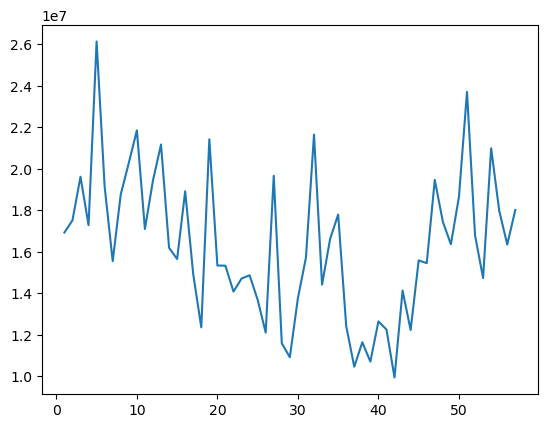

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

La verdad el early stopping fue MUY temprano, en la epoca 6, de igual forma veamos qué tal se desempeña nuestro modelo con respecto a 5 oraciones de prueba/validación

### Carga del modelo

In [147]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model.save("my_model")
model = keras.models.load_model('my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


### Generación de secuencias

In [148]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

Probemos el modelo con 5 versos y veamos que tan bien predice nuestro modelo

Versos a probar:

- would be cold that's why i got a heater for your thighs
- 'cause i really always knew that my little crime
- (heart bleeds but not for fellow men)
- the left isn't better
- before the story begins, is it such a sin,

In [149]:
input_texts_original = [
    "would be cold that's why i got a heater for your thighs",
    "'cause i really always knew that my little crime",
    "(heart bleeds but not for fellow men)",
    "the left isn't better",
    "before the story begins, is it such a sin,"
]

In [150]:
input_texts_early_stopping = [
    "would be cold that's why",
    "'cause i really always",
    "heart bleeds but",
    "the left",
    "before the story"]

In [151]:
generated_text_array = []

for input_text in input_texts_early_stopping:
    generated_text = generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)
    print(f"Input: {input_text}\nGenerated: {generated_text}\n")
    generated_text_array.append(generated_text)

1/1 [==============================] - 0s 15ms/step
Input: would be cold that's why
Generated: would be cold that's why i got a heater for your thighs a fire his

1/1 [==============================] - 0s 14ms/step
Input: 'cause i really always
Generated: 'cause i really always knew that my little crime never right to move on

1/1 [==============================] - 0s 14ms/step
Input: heart bleeds but
Generated: heart bleeds but not for fellow men men men men wish i'd know

1/1 [==============================] - 0s 15ms/step
Input: the left
Generated: the left isn't better i'll would try so hard but you gotta

1/1 [==============================] - 0s 14ms/step
Input: before the story
Generated: before the story begins is it such a fucking thing to the country



In [152]:
# Print 5 values of generated_text_array
for i in range(5):
    
    print(f"Original {i+1}: {input_texts_original[i]}")
    print(f"Input {i+1}: {input_texts_early_stopping[i]}")
    print(f"Generado {i+1}: {generated_text_array[i]}")
    print("\n")    

Original 1: would be cold that's why i got a heater for your thighs
Input 1: would be cold that's why
Generado 1: would be cold that's why i got a heater for your thighs a fire his


Original 2: 'cause i really always knew that my little crime
Input 2: 'cause i really always
Generado 2: 'cause i really always knew that my little crime never right to move on


Original 3: (heart bleeds but not for fellow men)
Input 3: heart bleeds but
Generado 3: heart bleeds but not for fellow men men men men wish i'd know


Original 4: the left isn't better
Input 4: the left
Generado 4: the left isn't better i'll would try so hard but you gotta


Original 5: before the story begins, is it such a sin,
Input 5: before the story
Generado 5: before the story begins is it such a fucking thing to the country




Nuestras secuencias generadas en realidad son bastante precisas, veamos que tal nos va con beam search

###  Beam search y muestreo aleatorio

In [153]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [154]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

Para esta seccion, usemos el siguiente verso: ***'Pictures and some memories will have to help me through, oh yeah'***

Probemos con el beam search deterministico, sorteando las probabilidades maximas en order descendientes y seleccionando la primera de esta lista

In [166]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=8,input="pictures and some memories",mode='det')

In [167]:
# veamos las salidas
print("Texto Original: Pictures and some memories will have to help me through, oh yeah")
print("Texto de input: pictures and some memories")
print("Texto predicho:")
for salida in salidas:
  print(decode(salida))

Texto Original: Pictures and some memories will have to help me through, oh yeah
Texto de input: pictures and some memories
Texto predicho:
['pictures and some memories will have to help me through oh yeah']
['pictures and some memories will have to help me through oh oh']
['pictures and some memories will have to help me through yeah yeah']
['pictures and some memories will have to help me through me to']
['pictures and some memories will have to help me through another yeah']
['pictures and some memories will have to help me through me i']
['pictures and some memories will have to help me through yeah oh']
['pictures and some memories will have to help me through oh this']
['pictures and some memories will have to help me through oh where']
['pictures and some memories will have to help me through oh far']


Nuestro metodo deterministico funcionó exactamente como esperabamos, mostrando el resultado de mayor probabilidad primero y tambien infiriendo correctamente la secuencia del verso, las demas secuencias tampoco fueron tan malas en realidad, prediciendo las proximas 7 palabras en todos los beams como minimo

-------------------

Probemos ahora con el modelo estocastico y 3 tipos diferentes de temperatura:

- temp=1.5: Aumenta la aleatoriedad de las predicciones. La distribución de probabilidad se vuelve más uniforme, haciendo que el modelo sea más propenso a explorar palabras menos probables.
- temp=0.7: Disminuye la aleatoriedad de las predicciones. La distribución de probabilidad se vuelve más aguda, haciendo que el modelo sea más propenso a elegir las palabras más probables.
- temp=1.0: Las probabiliades no se escalan y la función softmax se aplica directamente a las probabiliades originales. Este es el comportamiento predeterminado sin ningún escalado de temperatura.

Sabiendo que el beam search es mas potente que el metodo de generacion de secuencias, utilizaremos solo una palabra para revisar qué hacen las temperaturas en cada escenario

In [174]:
temps = [1.5, 0.7, 1.0]
results = []

for temp in temps:
    salidas = beam_search(model, num_beams=10, num_words=20, input="pictures", temp=temp, mode='sto')
    for salida in salidas:
        decoded_sentence = decode(salida)
        results.append({'temp': temp, 'output': decoded_sentence})

results_df = pd.DataFrame(results)

In [173]:
print("Texto a predecir: Pictures and some memories will have to help me through, oh yeah")
print("Texto de input: pictures and some memories")

results_df.head(50)

Texto a predecir: Pictures and some memories will have to help me through, oh yeah
Texto de input: pictures and some memories


,temp,output
0,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]
1,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]
2,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]
3,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]
4,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]
5,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel that]
6,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]
7,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]
8,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]
9,1.5,[pictures and i take my life tonight 'cause i have the right to die how i wanna stay i feel wrong]


Analizando los resultados, se explica a la perfeccion el uso de cada temperatura:

La temperatura > 1, que introduce mayor aleatoriedad al momento de elegir candidatos, nos muestra que los resultados estan muy regados y tienen mayor dispersion en las palabras predichas.

Las temperaturas =<1 son mas 'conservadoras' en las predicciones, aunque debido a que nuestro modelo es bastante eficiente, podemos ver que los versos son predichos correctamente en su mayoria y en la mayoria de palabras, teniendo en cuenta que solo utilizamos una palabra como input!